Plotting Class 0 vs 1 with 2 components...
Saved plot: plots/decision_boundaries\class0_vs_class1_comp2.png


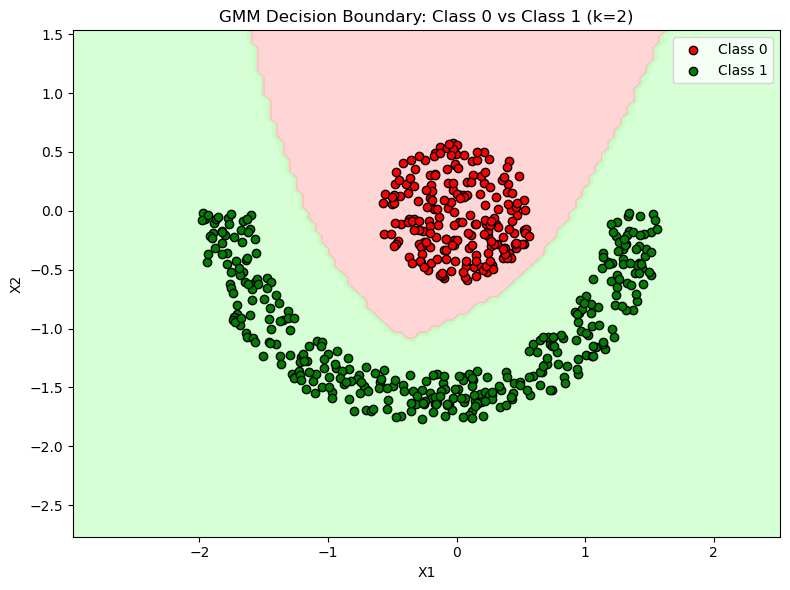

Plotting Class 0 vs 1 with 4 components...
Saved plot: plots/decision_boundaries\class0_vs_class1_comp4.png


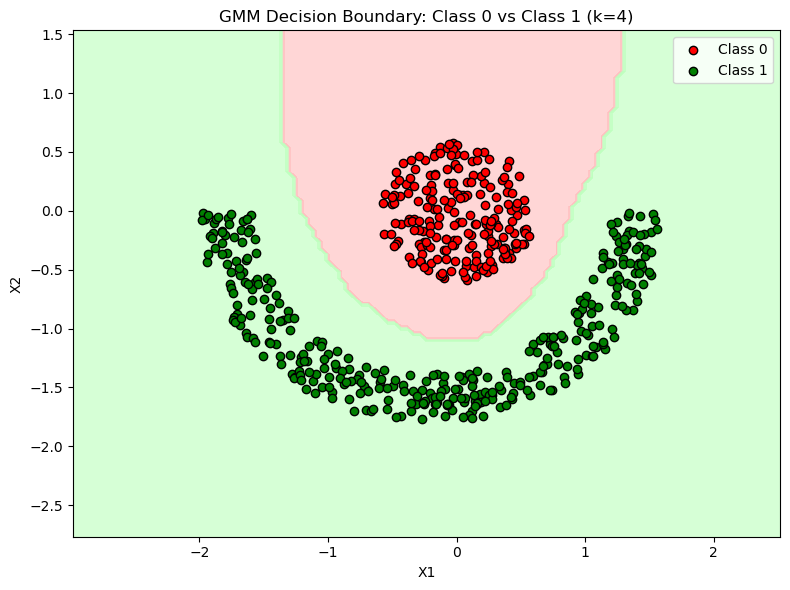

Plotting Class 0 vs 1 with 8 components...
Saved plot: plots/decision_boundaries\class0_vs_class1_comp8.png


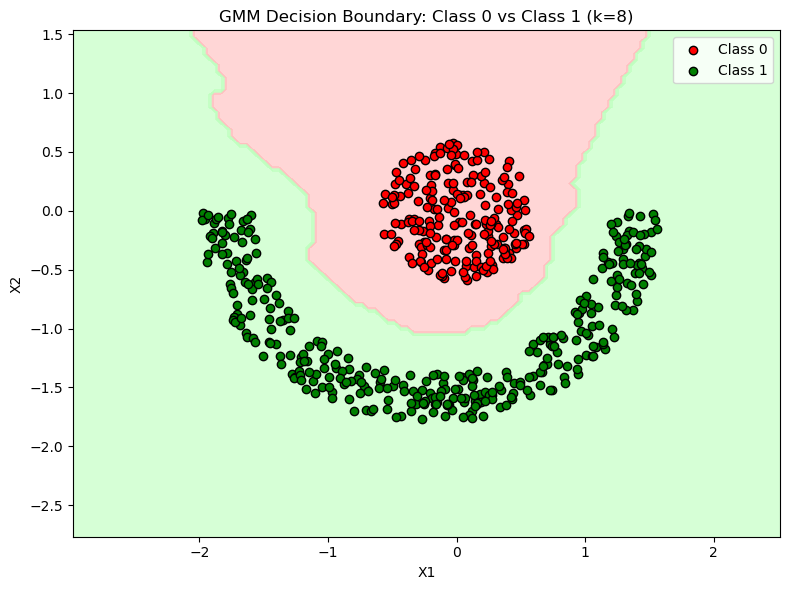

Plotting Class 0 vs 1 with 16 components...
Saved plot: plots/decision_boundaries\class0_vs_class1_comp16.png


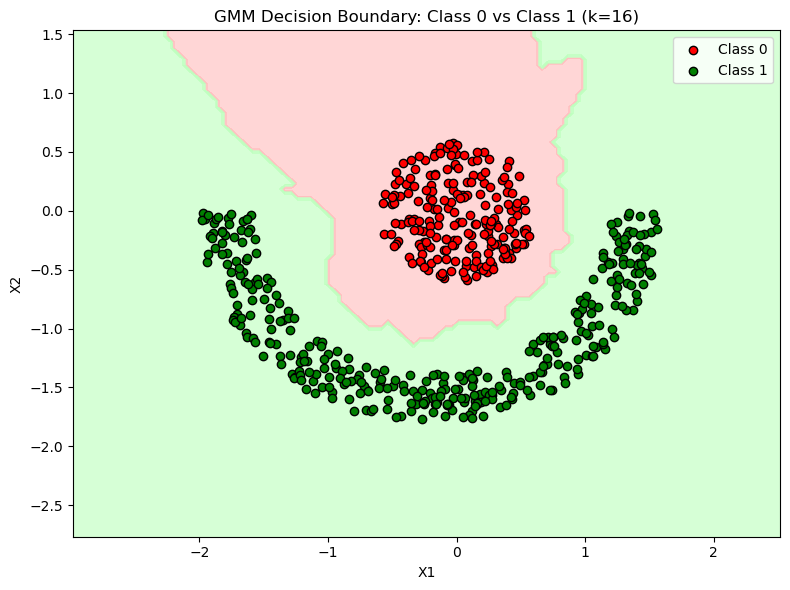

Plotting Class 0 vs 2 with 2 components...
Saved plot: plots/decision_boundaries\class0_vs_class2_comp2.png


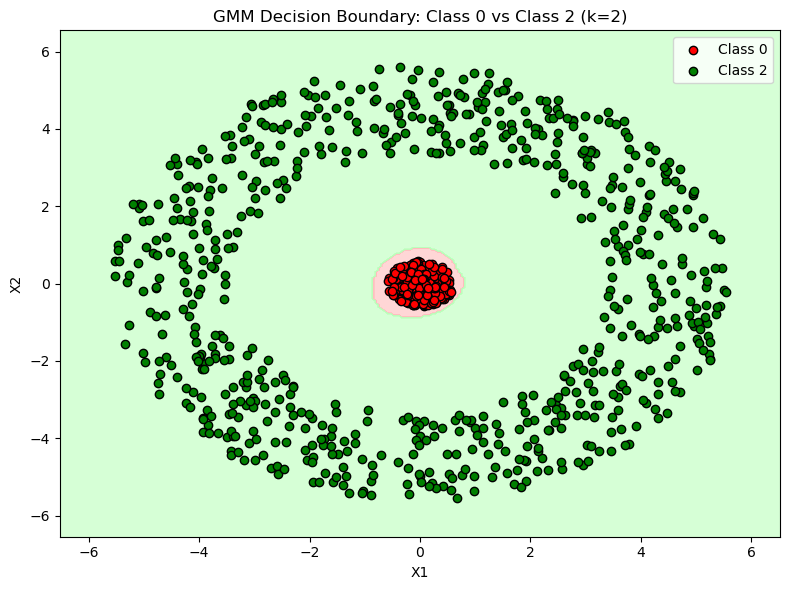

Plotting Class 0 vs 2 with 4 components...
Saved plot: plots/decision_boundaries\class0_vs_class2_comp4.png


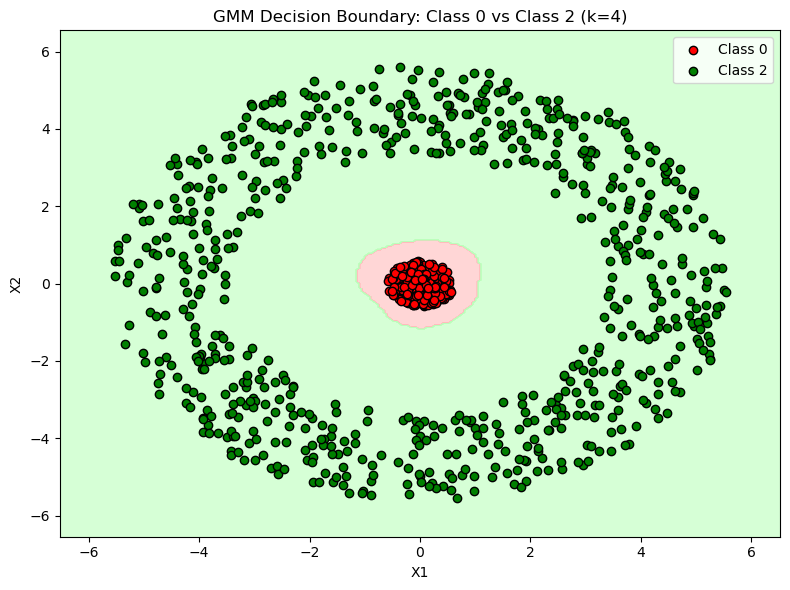

Plotting Class 0 vs 2 with 8 components...
Saved plot: plots/decision_boundaries\class0_vs_class2_comp8.png


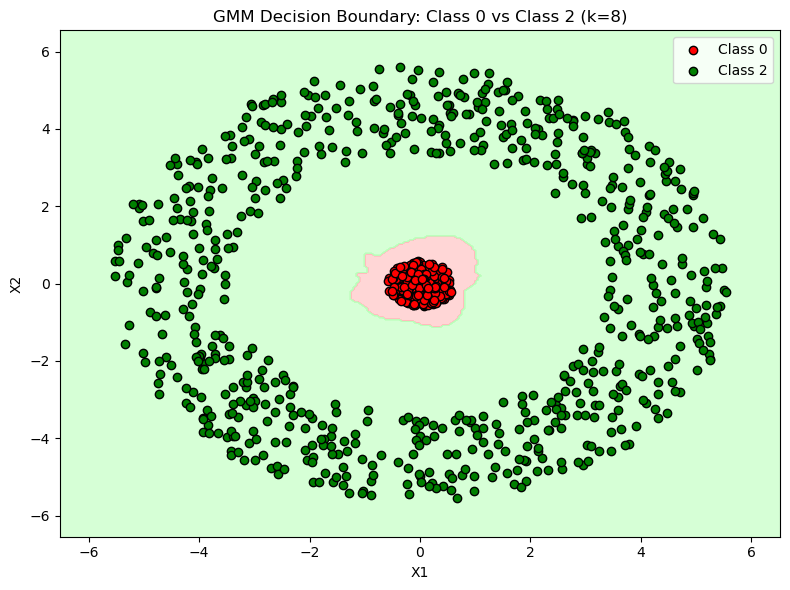

Plotting Class 0 vs 2 with 16 components...
Saved plot: plots/decision_boundaries\class0_vs_class2_comp16.png


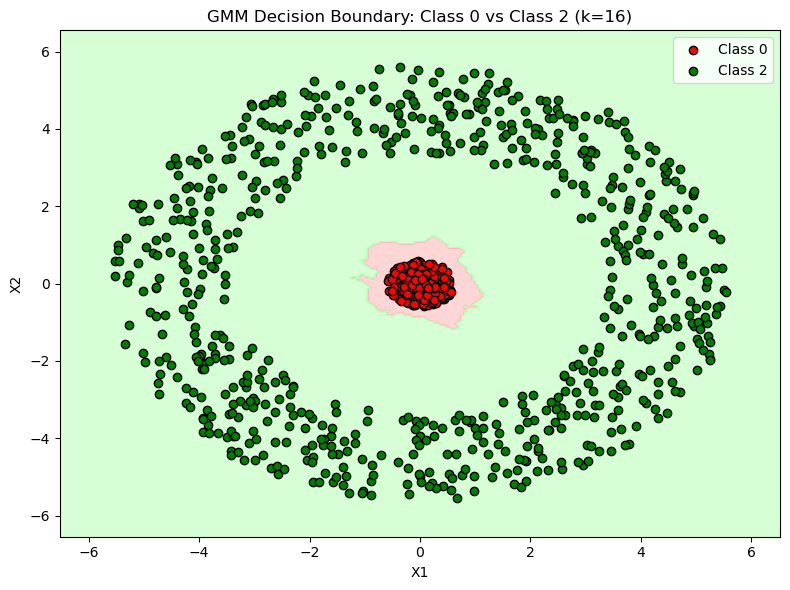

Plotting Class 1 vs 2 with 2 components...
Saved plot: plots/decision_boundaries\class1_vs_class2_comp2.png


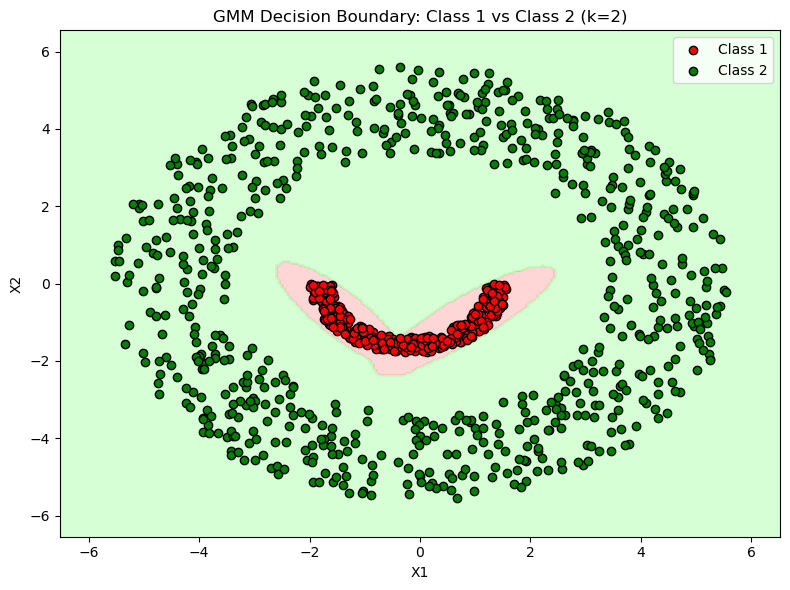

Plotting Class 1 vs 2 with 4 components...
Saved plot: plots/decision_boundaries\class1_vs_class2_comp4.png


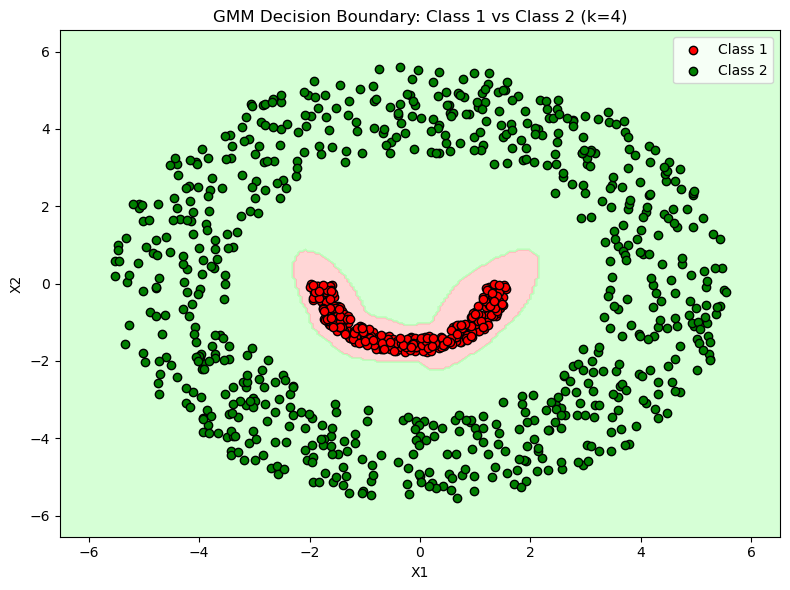

Plotting Class 1 vs 2 with 8 components...
Saved plot: plots/decision_boundaries\class1_vs_class2_comp8.png


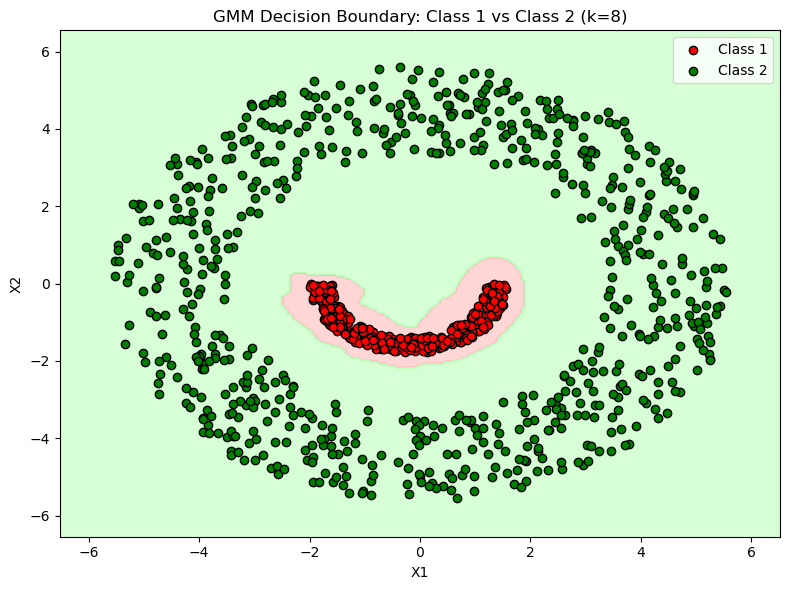

Plotting Class 1 vs 2 with 16 components...
Saved plot: plots/decision_boundaries\class1_vs_class2_comp16.png


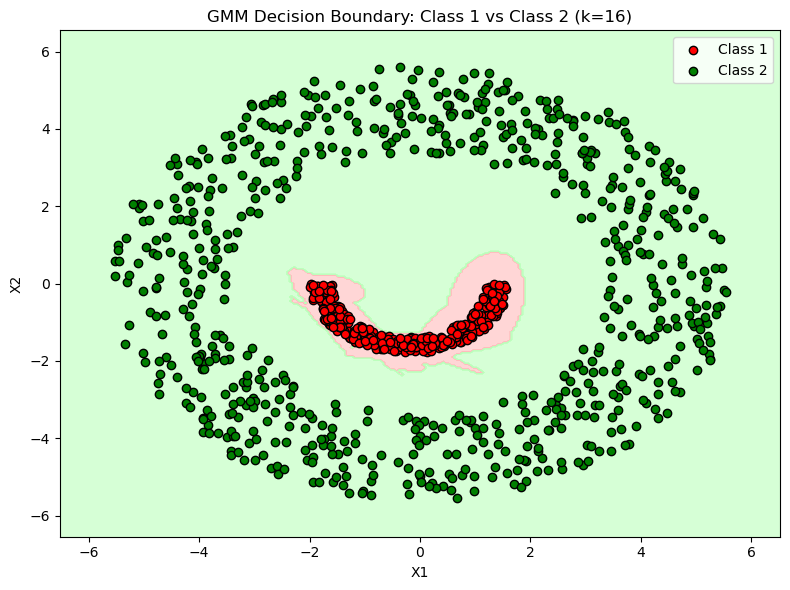

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from itertools import combinations
from matplotlib.colors import ListedColormap

# ---------------------------
# GMM from Scratch (EM Algo)
# ---------------------------

def initialize_gmm(X, n_components):
    n_samples, n_features = X.shape
    np.random.seed(42)
    indices = np.random.choice(n_samples, n_components, replace=False)
    means = X[indices]
    covs = [np.cov(X.T) + np.eye(n_features)*1e-6 for _ in range(n_components)]
    weights = np.ones(n_components) / n_components
    return means, covs, weights

def gaussian_density(x, mean, cov):
    d = len(x)
    cov_inv = np.linalg.inv(cov)
    diff = x - mean
    exp_term = -0.5 * np.dot(diff.T, np.dot(cov_inv, diff))
    denom = np.sqrt((2 * np.pi) ** d * np.linalg.det(cov) + 1e-6)
    return np.exp(exp_term) / (denom + 1e-6)

def gmm_em(X, n_components=2, max_iter=100, tol=1e-4):
    n_samples, n_features = X.shape
    means, covs, weights = initialize_gmm(X, n_components)
    log_likelihoods = []

    for iteration in range(max_iter):
        # E-step
        resp = np.zeros((n_samples, n_components))
        for k in range(n_components):
            for i in range(n_samples):
                resp[i, k] = weights[k] * gaussian_density(X[i], means[k], covs[k])
        resp_sum = np.sum(resp, axis=1, keepdims=True) + 1e-8
        resp /= resp_sum

        # M-step
        N_k = np.sum(resp, axis=0)
        for k in range(n_components):
            means[k] = np.sum(resp[:, k][:, np.newaxis] * X, axis=0) / N_k[k]
            diff = X - means[k]
            covs[k] = np.dot((resp[:, k][:, np.newaxis] * diff).T, diff) / N_k[k]
            covs[k] += np.eye(n_features) * 1e-6  # regularization
            weights[k] = N_k[k] / n_samples

        # Log likelihood
        log_likelihood = 0
        for i in range(n_samples):
            total = 0
            for k in range(n_components):
                total += weights[k] * gaussian_density(X[i], means[k], covs[k])
            log_likelihood += np.log(total + 1e-8)
        log_likelihoods.append(log_likelihood)

        if iteration > 0 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            break

    return means, covs, weights, log_likelihoods


# ---------------------------
# GMM Likelihood
# ---------------------------

def gmm_likelihood(x, means, covs, weights):
    return sum(w * gaussian_density(x, mu, cov) for w, mu, cov in zip(weights, means, covs))

# ---------------------------
# Plot 2-class decision boundary
# ---------------------------

def plot_2class_decision_boundary(X_pair, y_pair, model0, model1, prior0, prior1, class_labels, title="2-Class GMM Decision Boundary", save_path=None):
    h = 0.05
    x_min, x_max = X_pair[:, 0].min() - 1, X_pair[:, 0].max() + 1
    y_min, y_max = X_pair[:, 1].min() - 1, X_pair[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]

    Z = []
    for point in grid:
        p0 = gmm_likelihood(point, *model0) * prior0
        p1 = gmm_likelihood(point, *model1) * prior1
        Z.append(class_labels[0] if p0 > p1 else class_labels[1])
    Z = np.array(Z).reshape(xx.shape)

    cmap_light = ListedColormap(['#FFBBBB', '#BBFFBB'])
    cmap_bold = ListedColormap(['red', 'green'])

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.6)

    for class_value, color in zip(class_labels, ['red', 'green']):
        idx = np.where(y_pair == class_value)
        plt.scatter(X_pair[idx, 0], X_pair[idx, 1], c=color, label=f"Class {class_value}", edgecolor='k')

    plt.title(title)
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.legend()
    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300)
        print(f"Saved plot: {save_path}")
    plt.show()
    plt.close()

    
def load_train_test_datasets(base_folder):
    def load_folder(folder):
        data = []
        labels = []
        class_map = {}  # Maps class name to label (e.g. 'class1' → 0)

        files = [f for f in os.listdir(folder) if f.endswith(".txt")]
        files.sort()  # Optional: for consistent ordering

        for file in files:
            path = os.path.join(folder, file)
            parts = file.split("_")
            class_name = parts[0]  # 'class1' from 'class1_train.txt'

            # Assign numeric label to class name
            if class_name not in class_map:
                class_map[class_name] = len(class_map)  # auto-labeling

            label = class_map[class_name]

            points = np.loadtxt(path, delimiter=' ')
            data.append(points)
            labels.append(np.full(len(points), label))

        return np.vstack(data), np.hstack(labels), class_map

    train_folder = os.path.join(base_folder, "train")
    test_folder = os.path.join(base_folder, "test")

    X_train, y_train, class_map = load_folder(train_folder)
    X_test, y_test, _ = load_folder(test_folder)  # test uses same class_map, but we ignore it

    return X_train, y_train, X_test, y_test, class_map

# ---------------------------
# Main Demo
# ---------------------------

def main_demo():
    X_train, y_train, X_test, y_test, class_map = load_train_test_datasets(r'../../Dataset/Group04/NLS_Group04/')

    component_list = [2, 4, 8, 16]
    unique_classes = np.unique(y_train)

    for class0, class1 in combinations(unique_classes, 2):
        indices = np.where((y_train == class0) | (y_train == class1))[0]
        X_pair = X_train[indices]
        y_pair = y_train[indices]
        y_pair = np.array([class0 if y == class0 else class1 for y in y_pair])

        for n_comp in component_list:
            print(f"Plotting Class {class0} vs {class1} with {n_comp} components...")

            # Train GMMs
            X0 = X_pair[y_pair == class0]
            X1 = X_pair[y_pair == class1]

            means0, covs0, weights0, _ = gmm_em(X0, n_components=n_comp)
            means1, covs1, weights1, _ = gmm_em(X1, n_components=n_comp)

            model0 = (means0, covs0, weights0)
            model1 = (means1, covs1, weights1)

            prior0 = len(X0) / len(X_pair)
            prior1 = len(X1) / len(X_pair)

            # Save path
            save_dir = "plots/decision_boundaries"
            filename = f"class{class0}_vs_class{class1}_comp{n_comp}.png"
            save_path = os.path.join(save_dir, filename)

            plot_2class_decision_boundary(
                X_pair,
                y_pair,
                model0,
                model1,
                prior0,
                prior1,
                class_labels=[class0, class1],
                title=f"GMM Decision Boundary: Class {class0} vs Class {class1} (k={n_comp})",
                save_path=save_path
            )


if __name__ == "__main__":
    main_demo()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from itertools import product, combinations
from collections import defaultdict
from matplotlib.colors import ListedColormap

# ----------------------------
# Utility functions / GMM core
# ----------------------------
def gaussian_pdf(x, mean, cov):
    """Multivariate Gaussian PDF evaluated at point x (1-D array)."""
    d = len(x)
    # Regularize covariance to avoid singular
    cov_reg = cov + 1e-6 * np.eye(d)
    det = np.linalg.det(cov_reg)
    inv = np.linalg.inv(cov_reg)
    diff = x - mean
    exponent = diff.T @ inv @ diff
    denom = math.sqrt((2 * math.pi) ** d * det)
    return math.exp(-0.5 * exponent) / (denom + 1e-300)

def train_gmm(X, n_components=2, max_iters=20, tol=1e-4, alpha=1.0):
    """
    Train a Gaussian Mixture Model via EM on dataset X (shape: n × d).
    Returns: (means, covariances, weights, log_likelihoods)
    """
    n, d = X.shape

    # Initialization
    means = np.array([X[random.randint(0, n - 1)] for _ in range(n_components)])
    covs = np.array([np.eye(d) for _ in range(n_components)])
    weights = np.array([1.0 / n_components] * n_components)

    log_likelihoods = []

    for iteration in range(max_iters):
        # E-step: responsibilities
        resp = np.zeros((n, n_components))
        for i in range(n):
            for k in range(n_components):
                resp[i, k] = weights[k] * gaussian_pdf(X[i], means[k], covs[k])
            s = np.sum(resp[i, :])
            if s <= 0:
                resp[i, :] = 1.0 / n_components
            else:
                resp[i, :] /= s

        # Log-likelihood
        ll = 0.0
        for i in range(n):
            s = 0.0
            for k in range(n_components):
                s += weights[k] * gaussian_pdf(X[i], means[k], covs[k])
            ll += math.log(s + 1e-300)
        log_likelihoods.append(ll)

        # M-step: update parameters
        new_means = []
        new_covs = []
        new_weights = []

        for k in range(n_components):
            r_k = resp[:, k]
            Nk = np.sum(r_k)
            if Nk < 1e-8:
                # Reinitialize if component dies
                new_means.append(X[random.randint(0, n - 1)])
                new_covs.append(np.eye(d))
                new_weights.append(1.0 / n)
                continue

            # New mean
            m_k = np.sum(r_k.reshape(-1, 1) * X, axis=0) / Nk

            # New covariance
            cov_k = np.zeros((d, d))
            for i in range(n):
                diff = (X[i] - m_k).reshape(d, 1)
                cov_k += r_k[i] * (diff @ diff.T)
            cov_k /= Nk
            cov_k += 1e-6 * np.eye(d)  # regularization

            w_k = Nk / n

            # Smoothing/blending (if alpha < 1)
            m_k = alpha * m_k + (1 - alpha) * means[k]
            cov_k = alpha * cov_k + (1 - alpha) * covs[k]
            w_k = alpha * w_k + (1 - alpha) * weights[k]

            new_means.append(m_k)
            new_covs.append(cov_k)
            new_weights.append(w_k)

        means = np.array(new_means)
        covs = np.array(new_covs)
        weights = np.array(new_weights)

        # Check for convergence
        if iteration > 0 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            break

    return means, covs, weights, log_likelihoods

def gmm_likelihood(x, means, covs, weights):
    """Compute total likelihood of x under the GMM (sum over mixture)."""
    total = 0.0
    for k in range(len(means)):
        total += weights[k] * gaussian_pdf(x, means[k], covs[k])
    return total

# ---------------------------------------
# Bayesian classifier using per-class GMM
# ---------------------------------------
def train_bayes_gmm(X_train, y_train, n_components=2, max_iters=20, alpha=1.0):
    """
    Train a Bayesian classifier using class-specific GMMs.
    Returns:
      - class_models: dict[class] = (means, covs, weights)
      - priors: dict[class] = prior probability
      - log_likelihoods_all: dict[class] = list of log-likelihoods per EM iteration
    """
    classes = sorted(set(y_train))
    class_data = {c: [] for c in classes}
    for x, y in zip(X_train, y_train):
        class_data[y].append(x)
    class_data = {c: np.array(class_data[c]) for c in classes}

    N = len(X_train)
    class_models = {}
    priors = {}
    log_likelihoods_all = {}

    for c in classes:
        Xc = class_data[c]
        priors[c] = len(Xc) / N
        means, covs, weights, ll = train_gmm(Xc, n_components, max_iters, alpha=alpha)
        class_models[c] = (means, covs, weights)
        log_likelihoods_all[c] = ll

    return class_models, priors, log_likelihoods_all

def predict_bayes_gmm(X_test, class_models, priors):
    """Predict class labels for X_test (n_samples × d)."""
    preds = []
    for x in X_test:
        post = {}
        for c, (means, covs, weights) in class_models.items():
            lik = gmm_likelihood(x, means, covs, weights)
            post[c] = lik * priors[c]
        # Choose class with highest posterior
        pred = max(post.items(), key=lambda item: item[1])[0]
        preds.append(pred)
    return preds

# ------------------
# Evaluation metrics
# ------------------
def compute_metrics(y_true, y_pred):
    classes = sorted(set(y_true) | set(y_pred))
    # confusion[c_true][c_pred]
    confusion = {c1: {c2: 0 for c2 in classes} for c1 in classes}
    for yt, yp in zip(y_true, y_pred):
        confusion[yt][yp] += 1

    precision = {}
    recall = {}
    f1 = {}

    for c in classes:
        tp = confusion[c][c]
        fp = sum(confusion[other][c] for other in classes if other != c)
        fn = sum(confusion[c][other] for other in classes if other != c)

        precision[c] = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall[c]    = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        if precision[c] + recall[c] > 0:
            f1[c] = 2 * precision[c] * recall[c] / (precision[c] + recall[c])
        else:
            f1[c] = 0.0

    mean_precision = sum(precision.values()) / len(classes)
    mean_recall = sum(recall.values()) / len(classes)
    mean_f1 = sum(f1.values()) / len(classes)
    accuracy = sum(confusion[c][c] for c in classes) / len(y_true)

    return {
        "confusion": confusion,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "mean_precision": mean_precision,
        "mean_recall": mean_recall,
        "mean_f1": mean_f1,
    }

# ----------------------------
# Visualization / Plotting
# ----------------------------
def plot_decision_regions(X, y, class_models, priors, grid_steps=200, title="Decision Regions"):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx = np.linspace(x_min, x_max, grid_steps)
    yy = np.linspace(y_min, y_max, grid_steps)
    grid = np.array(list(product(xx, yy)))
    Z = []
    for pt in grid:
        post = {c: gmm_likelihood(pt, *class_models[c]) * priors[c] for c in class_models}
        Z.append(max(post.items(), key=lambda kv: kv[1])[0])
    Z = np.array(Z).reshape((grid_steps, grid_steps))

    plt.contourf(xx, yy, Z.T, alpha=0.3, cmap=plt.cm.coolwarm)
    for c in sorted(set(y)):
        pts = X[np.where(np.array(y) == c)]
        plt.scatter(pts[:, 0], pts[:, 1], label=f"Class {c}")
    plt.title(title)
    plt.legend()
    plt.show()

def plot_density_contours(X, y, class_models, title="Density Contours"):
    plt.figure()
    colors = ['blue', 'red', 'green', 'purple', 'orange']
    classes = sorted(set(y))
    for idx, c in enumerate(classes):
        pts = X[np.where(np.array(y) == c)]
        plt.scatter(pts[:, 0], pts[:, 1], color=colors[idx], alpha=0.6, label=f"Class {c}")

    # For each class, plot GMM density contours
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx = np.linspace(x_min, x_max, 150)
    yy = np.linspace(y_min, y_max, 150)
    grid = np.array(list(product(xx, yy)))
    for idx, c in enumerate(classes):
        means, covs, weights = class_models[c]
        Z = np.zeros(len(grid))
        for k in range(len(means)):
            for i, pt in enumerate(grid):
                Z[i] += weights[k] * gaussian_pdf(pt, means[k], covs[k])
        Z = Z.reshape((150, 150))
        plt.contour(xx, yy, Z, levels=5, colors=colors[idx], linewidths=1)

    plt.title(title)
    plt.legend()
    plt.show()

def plot_2class_decision_boundary(X, y, model0, model1, prior0, prior1, title="2-Class GMM Decision Boundary"):
    h = 0.05
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]

    Z = []
    for pt in grid:
        p0 = gmm_likelihood(pt, *model0) * prior0
        p1 = gmm_likelihood(pt, *model1) * prior1
        Z.append(0 if p0 > p1 else 1)
    Z = np.array(Z).reshape(xx.shape)

    cmap_light = ListedColormap(['#FFBBBB', '#BBFFBB'])
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.6)

    for cls, color in zip([0, 1], ['red', 'green']):
        idx = np.where(np.array(y) == cls)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, label=f"Class {cls}", edgecolor='k')
    plt.title(title)
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.legend()
    plt.show()

# --------------------------
# Demo / Driver / Main logic
# --------------------------
def load_train_test_datasets(base_path):
    """
    Placeholder: load your datasets from base_path.
    Adjust this function depending on how your data is stored.
    E.g., you might read .npy, .csv, .mat, etc.
    Returns:
      X_train, y_train, X_test, y_test, class_map
    """
    # Example using .npy files:
    X_train = np.load(base_path + 'X_train.npy')
    y_train = np.load(base_path + 'y_train.npy')
    X_test = np.load(base_path + 'X_test.npy')
    y_test = np.load(base_path + 'y_test.npy')
    class_map = {c: c for c in np.unique(y_train)}
    return X_train, y_train, X_test, y_test, class_map

def run_experiments(X_train, y_train, X_test, y_test, comp_list=[1, 2, 3], max_iters=30):
    all_models = {}
    metrics_results = {}
    ll_curves = {}

    for comp in comp_list:
        models, priors, ll_all = train_bayes_gmm(X_train, y_train,
                                                 n_components=comp,
                                                 max_iters=max_iters,
                                                 alpha=1.0)
        preds = predict_bayes_gmm(X_test, models, priors)
        metrics = compute_metrics(y_test, preds)
        all_models[comp] = (models, priors)
        metrics_results[comp] = metrics
        ll_curves[comp] = ll_all

        print(f"Components = {comp}")
        print(" Accuracy:", metrics["accuracy"])
        print(" Precision:", metrics["precision"])
        print(" Recall:", metrics["recall"])
        print(" F1:", metrics["f1"])
        print(" Mean Precision/Recall/F1:", metrics["mean_precision"],
              metrics["mean_recall"], metrics["mean_f1"])
        print(" Confusion Matrix:", metrics["confusion"])
        print("-----")

    # Choose best by mean F1 (or choose your own criterion)
    best_comp = max(comp_list, key=lambda c: metrics_results[c]["mean_f1"])
    print("Best number of components:", best_comp)

    best_models, best_priors = all_models[best_comp]
    best_metrics = metrics_results[best_comp]

    # Plot on training data
    plot_decision_regions(X_train, y_train, best_models, best_priors,
                          title=f"Decision Regions (train), comp={best_comp}")
    plot_density_contours(X_train, y_train, best_models,
                          title=f"Density Contours, comp={best_comp}")

    # Plot log-likelihood curves (summed over classes)
    plt.figure()
    for comp in comp_list:
        ll_dict = ll_curves[comp]
        # sum over classes at each iteration index
        iters = min(len(ll_list) for ll_list in ll_dict.values())
        summed = [sum(ll_dict[c][i] for c in ll_dict) for i in range(iters)]
        plt.plot(summed, label=f"comp={comp}")
    plt.xlabel("Iteration")
    plt.ylabel("Summed Log Likelihood")
    plt.title("Log-Likelihood vs Iteration")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot decision regions for test data
    plot_decision_regions(X_test, y_test, best_models, best_priors,
                          title=f"Decision Regions (test), comp={best_comp}")

    print("Best model metrics (on test set):")
    print(" Accuracy:", best_metrics["accuracy"])
    print(" Precision per class:", best_metrics["precision"])
    print(" Recall per class:", best_metrics["recall"])
    print(" F1 per class:", best_metrics["f1"])
    print(" Mean Precision/Recall/F1:", best_metrics["mean_precision"],
          best_metrics["mean_recall"], best_metrics["mean_f1"])
    print(" Confusion:", best_metrics["confusion"])

    return best_models, best_priors, best_metrics

def demo_synthetic():
    """Generate synthetic 3-class 2D data and run experiments."""
    np.random.seed(0)
    random.seed(0)

    mean_list = [[2, 2], [8, 2], [5, 7]]
    cov_list = [np.eye(2) * 1.0 for _ in mean_list]
    n_per_class = 100

    X, y = [], []
    for c in range(len(mean_list)):
        xs = np.random.multivariate_normal(mean_list[c], cov_list[c], n_per_class)
        X.append(xs)
        y += [c] * n_per_class
    X = np.vstack(X)
    y = np.array(y)

    perm = np.random.permutation(len(X))
    X = X[perm]
    y = y[perm]

    split = int(0.8 * len(X))
    X_train, y_train = X[:split], y[:split]
    X_test,  y_test  = X[split:], y[split:]

    return run_experiments(X_train, y_train, X_test, y_test, comp_list=[1, 2, 3])

def main():
    # Example of use with real dataset
    base_path = r'../../Dataset/Group04/NLS_Group04/'
    X_train, y_train, X_test, y_test, class_map = load_train_test_datasets(base_path)
    run_experiments(X_train, y_train, X_test, y_test, comp_list=[1, 2, 3], max_iters=30)

if __name__ == "__main__":
    # Uncomment one of the following:
    # 1. To run synthetic demo:
    # demo_synthetic()

    # 2. To run on your real dataset:
    main()


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import pickle
from itertools import product
from matplotlib.colors import ListedColormap

# ----------------------------
# Utility functions / GMM core
# ----------------------------
def gaussian_pdf(x, mean, cov):
    """Multivariate Gaussian PDF evaluated at point x (1-D array)."""
    d = len(x)
    cov_reg = cov + 1e-6 * np.eye(d)
    det = np.linalg.det(cov_reg)
    inv = np.linalg.inv(cov_reg)
    diff = x - mean
    exponent = diff.T @ inv @ diff
    denom = math.sqrt((2 * math.pi) ** d * det)
    return math.exp(-0.5 * exponent) / (denom + 1e-300)

def train_gmm(X, n_components=2, max_iters=20, tol=1e-4, alpha=1.0):
    """Train a Gaussian Mixture Model via EM on dataset X (shape: n × d)."""
    n, d = X.shape
    means = np.array([X[random.randint(0, n - 1)] for _ in range(n_components)])
    covs = np.array([np.eye(d) for _ in range(n_components)])
    weights = np.array([1.0 / n_components] * n_components)
    log_likelihoods = []

    for iteration in range(max_iters):
        # E-step
        resp = np.zeros((n, n_components))
        for i in range(n):
            for k in range(n_components):
                resp[i, k] = weights[k] * gaussian_pdf(X[i], means[k], covs[k])
            s = np.sum(resp[i, :])
            resp[i, :] = (resp[i, :] / s) if s > 0 else 1.0 / n_components

        # Log-likelihood
        ll = 0.0
        for i in range(n):
            s = sum(weights[k] * gaussian_pdf(X[i], means[k], covs[k]) for k in range(n_components))
            ll += math.log(s + 1e-300)
        log_likelihoods.append(ll)

        # M-step
        new_means, new_covs, new_weights = [], [], []
        for k in range(n_components):
            r_k = resp[:, k]
            Nk = np.sum(r_k)
            if Nk < 1e-8:
                new_means.append(X[random.randint(0, n - 1)])
                new_covs.append(np.eye(d))
                new_weights.append(1.0 / n)
                continue
            m_k = np.sum(r_k.reshape(-1, 1) * X, axis=0) / Nk
            cov_k = np.zeros((d, d))
            for i in range(n):
                diff = (X[i] - m_k).reshape(d, 1)
                cov_k += r_k[i] * (diff @ diff.T)
            cov_k /= Nk
            cov_k += 1e-6 * np.eye(d)
            w_k = Nk / n

            # smoothing
            m_k = alpha * m_k + (1 - alpha) * means[k]
            cov_k = alpha * cov_k + (1 - alpha) * covs[k]
            w_k = alpha * w_k + (1 - alpha) * weights[k]

            new_means.append(m_k)
            new_covs.append(cov_k)
            new_weights.append(w_k)

        means, covs, weights = np.array(new_means), np.array(new_covs), np.array(new_weights)
        if iteration > 0 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            break

    return means, covs, weights, log_likelihoods

def gmm_likelihood(x, means, covs, weights):
    total = 0.0
    for k in range(len(means)):
        total += weights[k] * gaussian_pdf(x, means[k], covs[k])
    return total

# ---------------------------------------
# Bayesian classifier using per-class GMM
# ---------------------------------------
def train_bayes_gmm(X_train, y_train, n_components=2, max_iters=20, alpha=1.0):
    classes = sorted(set(y_train))
    class_data = {c: np.array([x for x, y in zip(X_train, y_train) if y == c]) for c in classes}

    N = len(X_train)
    class_models, priors, log_likelihoods_all = {}, {}, {}
    for c in classes:
        Xc = class_data[c]
        priors[c] = len(Xc) / N
        means, covs, weights, ll = train_gmm(Xc, n_components, max_iters, alpha=alpha)
        class_models[c] = (means, covs, weights)
        log_likelihoods_all[c] = ll
    return class_models, priors, log_likelihoods_all

def predict_bayes_gmm(X_test, class_models, priors):
    preds = []
    for x in X_test:
        post = {c: gmm_likelihood(x, *class_models[c]) * priors[c] for c in class_models}
        preds.append(max(post.items(), key=lambda kv: kv[1])[0])
    return preds

# ------------------
# Evaluation metrics
# ------------------
def compute_metrics(y_true, y_pred):
    classes = sorted(set(y_true) | set(y_pred))
    confusion = {c1: {c2: 0 for c2 in classes} for c1 in classes}
    for yt, yp in zip(y_true, y_pred):
        confusion[yt][yp] += 1

    precision, recall, f1 = {}, {}, {}
    for c in classes:
        tp = confusion[c][c]
        fp = sum(confusion[other][c] for other in classes if other != c)
        fn = sum(confusion[c][other] for other in classes if other != c)
        precision[c] = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall[c] = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1[c] = (2 * precision[c] * recall[c] / (precision[c] + recall[c])) if (precision[c] + recall[c]) > 0 else 0

    mean_p = np.mean(list(precision.values()))
    mean_r = np.mean(list(recall.values()))
    mean_f = np.mean(list(f1.values()))
    accuracy = sum(confusion[c][c] for c in classes) / len(y_true)
    return {
        "confusion": confusion,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "mean_precision": mean_p,
        "mean_recall": mean_r,
        "mean_f1": mean_f,
    }

# ----------------------------
# Visualization / Plotting
# ----------------------------
def plot_decision_regions(X, y, class_models, priors, grid_steps=200, title="Decision Regions"):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx = np.linspace(x_min, x_max, grid_steps)
    yy = np.linspace(y_min, y_max, grid_steps)
    grid = np.array(list(product(xx, yy)))
    Z = []
    for pt in grid:
        post = {c: gmm_likelihood(pt, *class_models[c]) * priors[c] for c in class_models}
        Z.append(max(post.items(), key=lambda kv: kv[1])[0])
    Z = np.array(Z).reshape((grid_steps, grid_steps))

    plt.contourf(xx, yy, Z.T, alpha=0.3, cmap=plt.cm.coolwarm)
    for c in sorted(set(y)):
        pts = X[np.where(np.array(y) == c)]
        plt.scatter(pts[:, 0], pts[:, 1], label=f"Class {c}")
    plt.title(title)
    plt.legend()
    plt.show()

# --------------------------
# Dataset Loader
# --------------------------
def load_train_test_datasets(base_path):
    X_train = np.load(base_path + 'X_train.npy')
    y_train = np.load(base_path + 'y_train.npy')
    X_test = np.load(base_path + 'X_test.npy')
    y_test = np.load(base_path + 'y_test.npy')
    class_map = {c: c for c in np.unique(y_train)}
    return X_train, y_train, X_test, y_test, class_map

# --------------------------
# Experiment Runner
# --------------------------
def run_experiments(X_train, y_train, X_test, y_test, comp_list=[1, 2, 3], max_iters=30, save_path=None):
    experiments = {}
    for comp in comp_list:
        print(f"\n🔍 Running experiment with {comp} GMM components...")
        models, priors, ll_all = train_bayes_gmm(X_train, y_train, n_components=comp, max_iters=max_iters, alpha=1.0)
        preds = predict_bayes_gmm(X_test, models, priors)
        metrics = compute_metrics(y_test, preds)
        experiments[comp] = {'models': models, 'priors': priors, 'predictions': preds, 'metrics': metrics, 'log_likelihoods': ll_all}

        print(f" Accuracy: {metrics['accuracy']:.4f}")
        print(f" Mean F1: {metrics['mean_f1']:.4f}")
        print(" Confusion Matrix:", metrics["confusion"])

    if save_path:
        with open(save_path, 'wb') as f:
            pickle.dump(experiments, f)
        print(f"✅ Saved all experiment results to {save_path}")

    return experiments

def load_experiments(save_path):
    with open(save_path, 'rb') as f:
        experiments = pickle.load(f)
    print(f"✅ Loaded experiments from {save_path}")
    return experiments

# --------------------------
# Main
# --------------------------
def main():
    base_path = r'../../Dataset/Group04/NLS_Group04/'
    X_train, y_train, X_test, y_test, class_map = load_train_test_datasets(base_path)
    experiments = run_experiments(X_train, y_train, X_test, y_test, comp_list=[1, 2, 3], max_iters=30, save_path="experiments_gmm.pkl")

    # Example: visualize for best model (say 2 components)
    experiment_2 = experiments[2]
    models = experiment_2['models']
    priors = experiment_2['priors']
    metrics = experiment_2['metrics']
    print("\n✅ Best Model (2 Components) Accuracy:", metrics['accuracy'])
    plot_decision_regions(X_test, y_test, models, priors, title="Decision Boundary (Test Data)")

if __name__ == "__main__":
    main()


FileNotFoundError: [Errno 2] No such file or directory: '../../Dataset/Group04/NLS_Group04/X_train.npy'

✅ Loaded dataset: 1260 train samples, 540 test samples.

🔍 Running with 1 components
Accuracy = 0.9852, Mean F1 = 0.9865
Confusion Matrix: {0: {0: 90, 1: 0, 2: 0}, 1: {0: 0, 1: 142, 2: 8}, 2: {0: 0, 1: 0, 2: 300}}


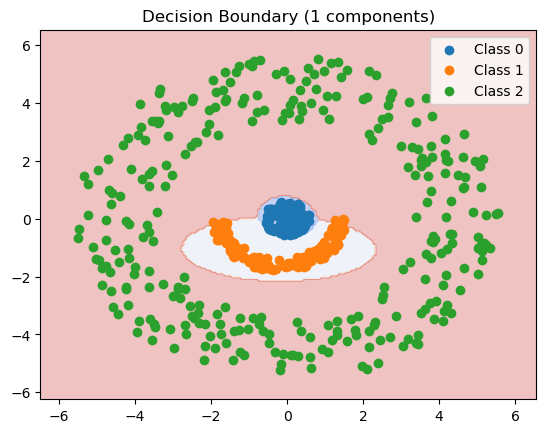


🔍 Running with 2 components
Accuracy = 1.0000, Mean F1 = 1.0000
Confusion Matrix: {0: {0: 90, 1: 0, 2: 0}, 1: {0: 0, 1: 150, 2: 0}, 2: {0: 0, 1: 0, 2: 300}}


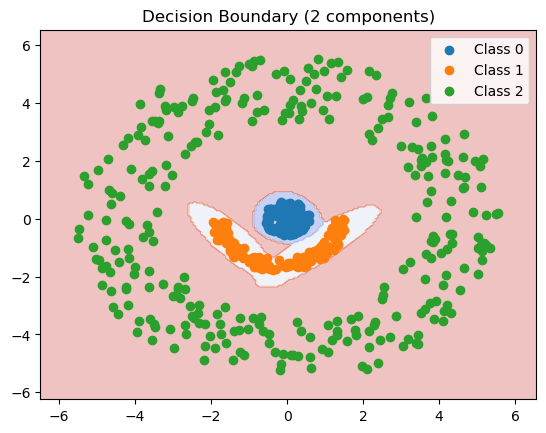


🔍 Running with 3 components
Accuracy = 1.0000, Mean F1 = 1.0000
Confusion Matrix: {0: {0: 90, 1: 0, 2: 0}, 1: {0: 0, 1: 150, 2: 0}, 2: {0: 0, 1: 0, 2: 300}}


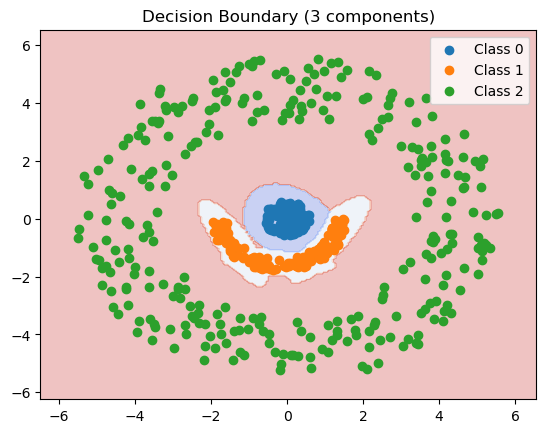

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random, math, os, pickle
from itertools import product

# ----------------------------
# Utility functions / GMM core
# ----------------------------
def gaussian_pdf(x, mean, cov):
    d = len(x)
    cov_reg = cov + 1e-6 * np.eye(d)
    det = np.linalg.det(cov_reg)
    inv = np.linalg.inv(cov_reg)
    diff = x - mean
    exponent = diff.T @ inv @ diff
    denom = math.sqrt((2 * math.pi) ** d * det)
    return math.exp(-0.5 * exponent) / (denom + 1e-300)

def train_gmm(X, n_components=2, max_iters=20, tol=1e-4, alpha=1.0):
    n, d = X.shape
    means = np.array([X[random.randint(0, n - 1)] for _ in range(n_components)])
    covs = np.array([np.eye(d) for _ in range(n_components)])
    weights = np.array([1.0 / n_components] * n_components)
    log_likelihoods = []

    for iteration in range(max_iters):
        # E-step
        resp = np.zeros((n, n_components))
        for i in range(n):
            for k in range(n_components):
                resp[i, k] = weights[k] * gaussian_pdf(X[i], means[k], covs[k])
            s = np.sum(resp[i, :])
            resp[i, :] = (resp[i, :] / s) if s > 0 else 1.0 / n_components

        # Log-likelihood
        ll = 0.0
        for i in range(n):
            s = sum(weights[k] * gaussian_pdf(X[i], means[k], covs[k]) for k in range(n_components))
            ll += math.log(s + 1e-300)
        log_likelihoods.append(ll)

        # M-step
        new_means, new_covs, new_weights = [], [], []
        for k in range(n_components):
            r_k = resp[:, k]
            Nk = np.sum(r_k)
            if Nk < 1e-8:
                new_means.append(X[random.randint(0, n - 1)])
                new_covs.append(np.eye(d))
                new_weights.append(1.0 / n)
                continue
            m_k = np.sum(r_k.reshape(-1, 1) * X, axis=0) / Nk
            cov_k = np.zeros((d, d))
            for i in range(n):
                diff = (X[i] - m_k).reshape(d, 1)
                cov_k += r_k[i] * (diff @ diff.T)
            cov_k /= Nk
            cov_k += 1e-6 * np.eye(d)
            w_k = Nk / n

            # smoothing
            m_k = alpha * m_k + (1 - alpha) * means[k]
            cov_k = alpha * cov_k + (1 - alpha) * covs[k]
            w_k = alpha * w_k + (1 - alpha) * weights[k]

            new_means.append(m_k)
            new_covs.append(cov_k)
            new_weights.append(w_k)

        means, covs, weights = np.array(new_means), np.array(new_covs), np.array(new_weights)
        if iteration > 0 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            break

    return means, covs, weights, log_likelihoods

def gmm_likelihood(x, means, covs, weights):
    return sum(weights[k] * gaussian_pdf(x, means[k], covs[k]) for k in range(len(means)))

# --------------------------
# Bayesian GMM Classifier
# --------------------------
def train_bayes_gmm(X_train, y_train, n_components=2, max_iters=20, alpha=1.0):
    classes = sorted(set(y_train))
    class_data = {c: np.array([x for x, y in zip(X_train, y_train) if y == c]) for c in classes}

    N = len(X_train)
    class_models, priors, log_likelihoods_all = {}, {}, {}
    for c in classes:
        Xc = class_data[c]
        priors[c] = len(Xc) / N
        means, covs, weights, ll = train_gmm(Xc, n_components, max_iters, alpha=alpha)
        class_models[c] = (means, covs, weights)
        log_likelihoods_all[c] = ll
    return class_models, priors, log_likelihoods_all

def predict_bayes_gmm(X_test, class_models, priors):
    preds = []
    for x in X_test:
        post = {c: gmm_likelihood(x, *class_models[c]) * priors[c] for c in class_models}
        preds.append(max(post.items(), key=lambda kv: kv[1])[0])
    return preds

# --------------------------
# Evaluation metrics
# --------------------------
def compute_metrics(y_true, y_pred):
    classes = sorted(set(y_true) | set(y_pred))
    confusion = {c1: {c2: 0 for c2 in classes} for c1 in classes}
    for yt, yp in zip(y_true, y_pred):
        confusion[yt][yp] += 1

    precision, recall, f1 = {}, {}, {}
    for c in classes:
        tp = confusion[c][c]
        fp = sum(confusion[other][c] for other in classes if other != c)
        fn = sum(confusion[c][other] for other in classes if other != c)
        precision[c] = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall[c] = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1[c] = (2 * precision[c] * recall[c] / (precision[c] + recall[c])) if (precision[c] + recall[c]) > 0 else 0

    mean_p = np.mean(list(precision.values()))
    mean_r = np.mean(list(recall.values()))
    mean_f = np.mean(list(f1.values()))
    accuracy = sum(confusion[c][c] for c in classes) / len(y_true)
    return {
        "confusion": confusion,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "mean_precision": mean_p,
        "mean_recall": mean_r,
        "mean_f1": mean_f,
    }

# --------------------------
# Visualization
# --------------------------
def plot_decision_regions(X, y, class_models, priors, grid_steps=200, title="Decision Regions"):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx = np.linspace(x_min, x_max, grid_steps)
    yy = np.linspace(y_min, y_max, grid_steps)
    grid = np.array(list(product(xx, yy)))
    Z = []
    for pt in grid:
        post = {c: gmm_likelihood(pt, *class_models[c]) * priors[c] for c in class_models}
        Z.append(max(post.items(), key=lambda kv: kv[1])[0])
    Z = np.array(Z).reshape((grid_steps, grid_steps))

    plt.contourf(xx, yy, Z.T, alpha=0.3, cmap=plt.cm.coolwarm)
    for c in sorted(set(y)):
        pts = X[np.where(np.array(y) == c)]
        plt.scatter(pts[:, 0], pts[:, 1], label=f"Class {c}")
    plt.title(title)
    plt.legend()
    plt.show()

# --------------------------
# Your Dataset Loader
# --------------------------
def load_train_test_datasets(base_folder):
    def load_folder(folder):
        data, labels, class_map = [], [], {}
        files = [f for f in os.listdir(folder) if f.endswith(".txt")]
        files.sort()
        for file in files:
            path = os.path.join(folder, file)
            class_name = file.split("_")[0]
            if class_name not in class_map:
                class_map[class_name] = len(class_map)
            label = class_map[class_name]
            points = np.loadtxt(path, delimiter=' ')
            data.append(points)
            labels.append(np.full(len(points), label))
        return np.vstack(data), np.hstack(labels), class_map

    train_folder = os.path.join(base_folder, "train")
    test_folder = os.path.join(base_folder, "test")
    X_train, y_train, class_map = load_folder(train_folder)
    X_test, y_test, _ = load_folder(test_folder)
    return X_train, y_train, X_test, y_test, class_map

# --------------------------
# Run Experiments
# --------------------------
def run_experiments(X_train, y_train, X_test, y_test, comp_list=[1, 2, 3], max_iters=30):
    for comp in comp_list:
        print(f"\n🔍 Running with {comp} components")
        models, priors, _ = train_bayes_gmm(X_train, y_train, n_components=comp, max_iters=max_iters)
        preds = predict_bayes_gmm(X_test, models, priors)
        metrics = compute_metrics(y_test, preds)
        print(f"Accuracy = {metrics['accuracy']:.4f}, Mean F1 = {metrics['mean_f1']:.4f}")
        print("Confusion Matrix:", metrics["confusion"])
        plot_decision_regions(X_test, y_test, models, priors, title=f"Decision Boundary ({comp} components)")

# --------------------------
# Main Entry
# --------------------------
def main():
    base_path = r'../../Dataset/Group04/NLS_Group04/'
    X_train, y_train, X_test, y_test, class_map = load_train_test_datasets(base_path)
    print("✅ Loaded dataset:", len(X_train), "train samples,", len(X_test), "test samples.")
    run_experiments(X_train, y_train, X_test, y_test, comp_list=[1, 2, 3], max_iters=30)

if __name__ == "__main__":
    main()
